In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from nanonets import Simulation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.signal import find_peaks

plt.style.use(["science","bright","grid"])

CPU_CNT     = 32
U0_LIST     = np.linspace(0.01,0.05,CPU_CNT,endpoint=False)
N_VOLT      = 50000
TIME_STEP   = 1e-11
PLOT_NORM   = Normalize(vmin=1000*U0_LIST[0], vmax=1000*U0_LIST[-1])
CMAP        = plt.get_cmap('cividis')
# FOLDER      = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/DC/size_volt/"
# FOLDER      = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/DC/size_volt/"
FOLDER      = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/DC/size_volt/"
N_PARTICLES = [3,5,7,9]
MARKERS     = ['o','s','<','>','^']

def stretched_exp(t, tau, beta, I0):
    return I0*np.exp(-(t/tau)**beta)

### SET RC Time Constant

In [10]:
topo    = {"Nx" : 1, "Ny" : 1, "electrode_type" : ['constant','constant']}
sim_c   = Simulation(topo)
tau_t   = 25*sim_c.get_capacitance_matrix()[0][0]*1e6*1e-9 # in ns
kBT     = 1000 * sim_c.KB_AJ_PER_K * 0.1 / sim_c.ELE_CHARGE_A_C
print(f"Tau_RC = {tau_t}")

Tau_RC = 0.23628021769320412


### Load Relaxation Data

In [13]:
t       = np.arange(N_VOLT) * TIME_STEP
y_d     = {}
ye_d    = {}
I_d     = {}
for N_NP in N_PARTICLES:
    y   = np.array([pd.read_csv(f"{FOLDER}Nx={N_NP}_Ny={N_NP}_Ne=8_{V:.5f}.csv")['Observable'].values for V in U0_LIST]).T
    y   = np.vstack([np.zeros(len(U0_LIST)),y])
    y_e = np.array([pd.read_csv(f"{FOLDER}Nx={N_NP}_Ny={N_NP}_Ne=8_{V:.5f}.csv")['Error'].values for V in U0_LIST]).T
    y_e = np.vstack([np.zeros(len(U0_LIST)),y_e])
    y_d[N_NP]   = y
    ye_d[N_NP]  = y_e
    I   = np.array([(pd.read_csv(f"{FOLDER}net_currents_Nx={N_NP}_Ny={N_NP}_Ne=8_{V:.5f}.csv")/sim_c.ELE_CHARGE_A_C).values for V in U0_LIST])
    I_d[N_NP] = I

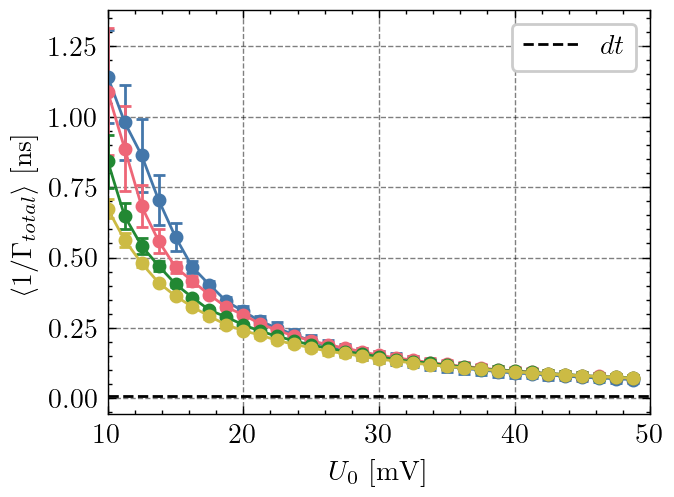

In [42]:
skip    = 0
idx     = 100
V_write = np.array(U0_LIST[skip:])*1000
fig, ax = plt.subplots(dpi=200)

for N_NP in N_PARTICLES:
    tau         = (1e9/np.sum(I_d[N_NP][:,:idx,:], axis=2))[skip:,:]
    tau_median  = np.median(tau, axis=1)
    tau_mean    = np.mean(tau, axis=1)
    tau_std     = np.std(tau, axis=1)
    tau_ci_u    = np.quantile(tau, 0.975, axis=1)
    tau_ci_l    = np.quantile(tau, 0.025, axis=1)

    # _ = ax.errorbar(V_write, tau_median, [tau_ci_l,tau_ci_u], marker='o', ms=4, capsize=2)
    _ = ax.errorbar(V_write, tau_mean, tau_std, marker='o', ms=4, capsize=2)
# _ = ax.hlines(tau_t, 10, 50, colors='black', label='$\\tau_{SET} = R \cdot C$', ls='--')
_ = ax.hlines(TIME_STEP*1e9, 10, 50, colors='black', label='$dt$', ls='--')
_ = ax.legend()
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$\\langle 1/\\Gamma_{total} \\rangle$ [ns]")
_ = ax.set_xlim(10, 50)
# _ = ax.set_ylim(0.0009,1e1)
# ax.set_yscale('log')

fig.savefig(f"plots/png/relaxation/current_gamma_tau_vs_U.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/current_gamma_tau_vs_U.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/current_gamma_tau_vs_U.svg", transparent=True)

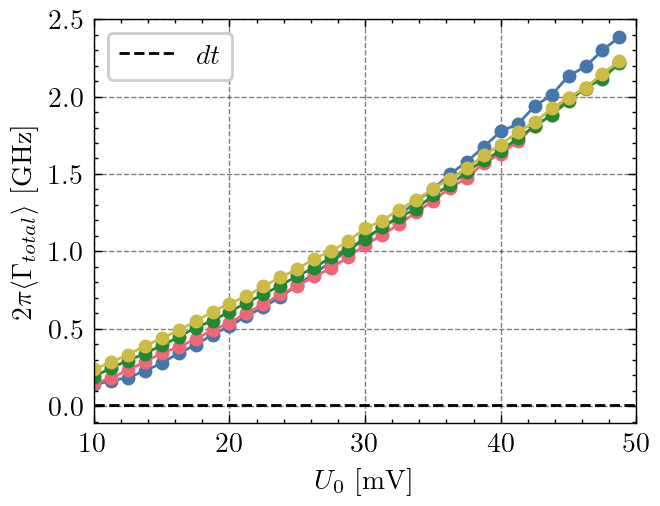

In [45]:
skip    = 0
idx     = 100
V_write = np.array(U0_LIST[skip:])*1000
fig, ax = plt.subplots(dpi=200)

for N_NP in N_PARTICLES:
    tau         = (1e9/np.sum(I_d[N_NP][:,:idx,:], axis=2))[skip:,:]
    tau_median  = np.median(tau, axis=1)
    tau_mean    = np.mean(tau, axis=1)
    tau_std     = np.std(tau, axis=1)
    tau_ci_u    = np.quantile(tau, 0.975, axis=1)
    tau_ci_l    = np.quantile(tau, 0.025, axis=1)

    # _ = ax.errorbar(V_write, tau_median, [tau_ci_l,tau_ci_u], marker='o', ms=4, capsize=2)
    _ = ax.errorbar(V_write, 1/(2*np.pi*tau_mean), marker='o', ms=4)
# _ = ax.hlines(tau_t, 10, 50, colors='black', label='$\\tau_{SET} = R \cdot C$', ls='--')
_ = ax.hlines(TIME_STEP*1e9, 10, 50, colors='black', label='$dt$', ls='--')
_ = ax.legend()
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$2\\pi\\langle \\Gamma_{total} \\rangle$ [GHz]")
_ = ax.set_xlim(10, 50)
# _ = ax.set_ylim(0.0009,1e1)
# ax.set_yscale('log')

fig.savefig(f"plots/png/relaxation/current_gamma_f_vs_U.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/current_gamma_f_vs_U.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/current_gamma_f_vs_U.svg", transparent=True)

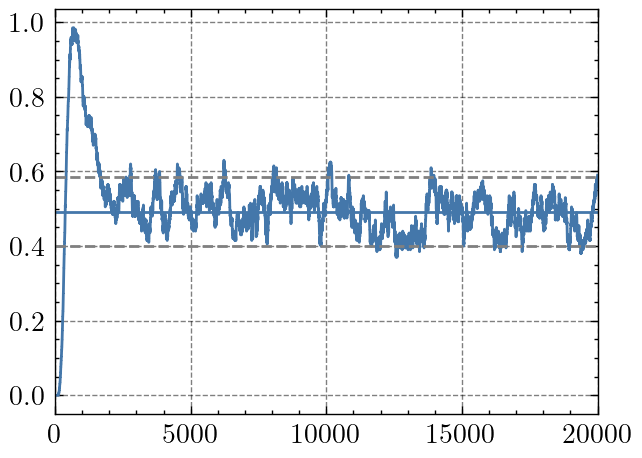

In [35]:
i       = 8
N_NP    = 11
n_max   = 20000
fig, ax = plt.subplots(dpi=200)
y_copy  = np.round(y_d[N_NP][:,i].copy()*1e-9,4)/U0_LIST[i]
ax.plot(y_copy)
ax.hlines(np.median(y_copy[:-1000]),0,n_max)
ax.hlines(np.quantile(y_copy[:-1000],0.05),0,n_max, color='grey', ls='dashed')
ax.hlines(np.quantile(y_copy[:-1000],0.95),0,n_max, color='grey', ls='dashed')
_ = ax.set_xlim(0, n_max)

### Time Constants

In [48]:
skip    = 0
min_con = 5
sat     = 1000
p_sat   = 0.8
taus_d  = {}
cvs_d   = {}
for N_NP in N_PARTICLES:
    taus    = []
    cvs     = []
    for i, V in enumerate(U0_LIST[skip:]):

        # Copy data
        t_copy  = t.copy()*1e9
        y_copy  = (y_d[N_NP][:,i+skip].copy()*1e-9)/V
        ye_copy = (ye_d[N_NP][:,i+skip].copy()*1e-9)/V

        # Get Saturation Values and Transient Part
        sat_mean = np.median(y_copy[-sat:])

        # threshold crossing: first index where y >= p_sat*sat_mean and persists for min_consec samples
        thresh  = p_sat * sat_mean
        above   = y_copy >= thresh

        # find first run of at least min_consec True
        idx_cut = None
        consec = 0
        for i, val in enumerate(above):
            if val:
                consec += 1
                if consec >= min_con:
                    idx_cut = i - (min_con - 1) + 1
                    break
            else:
                consec = 0
        
        t_plot  = t_copy[:idx_cut]
        y_plot  = y_copy[:idx_cut]
        
        # Get Tau and CV (model-free)
        # f       = (sat_mean - y_plot) / sat_mean
        f       = (np.max(y_plot) - y_plot) / np.max(y_plot)
        norm    = np.trapz(f, x=t_plot)
        tau     = np.trapz(t_plot * f, x=t_plot) / norm
        tau2    = np.trapz(t_plot**2 * f, x=t_plot) / norm
        sigma   = np.sqrt(tau2 - tau**2)
        cv      = sigma / tau

        # Append
        taus.append(tau)
        cvs.append(cv)
    taus_d[N_NP] = taus
    cvs_d[N_NP]  = cvs

/tmp/ipykernel_973/540999068.py:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  norm    = np.trapz(f, x=t_plot)
/tmp/ipykernel_973/540999068.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  tau     = np.trapz(t_plot * f, x=t_plot) / norm
/tmp/ipykernel_973/540999068.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  tau2    = np.trapz(t_plot**2 * f, x=t_plot) / norm


[36.32311926  1.25143594]
[3.89583258e+03 2.49964827e+00]
[6.29856625e+03 2.74369469e+00]
[4.48095376e+03 2.67797095e+00]


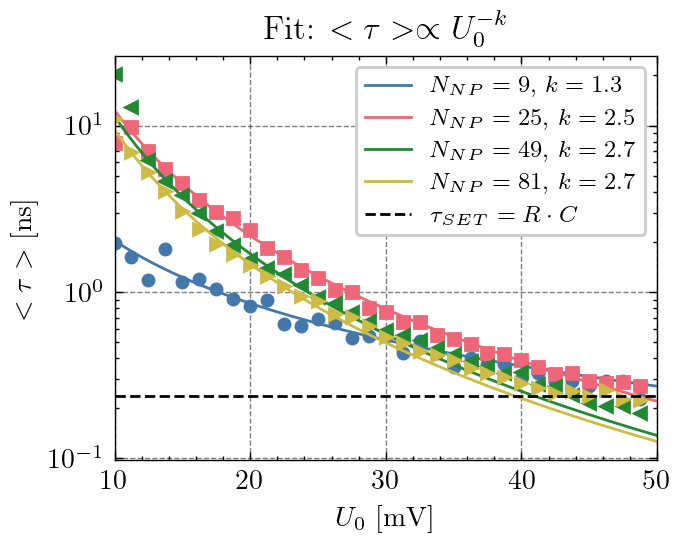

In [49]:
def power_law(x, A, k):
    return A*(x)**(-k)

min_V   = 12
max_V   = 40
fig, ax = plt.subplots(dpi=200)
V_write = np.array(U0_LIST[skip:])*1000
V_clean = V_write[(V_write < max_V) & ((V_write >= min_V))]
for i, N_NP in enumerate(N_PARTICLES):
    tau_clean   = np.array(taus_d[N_NP])[(V_write < max_V) & ((V_write >= min_V))]
    p, cov      = curve_fit(power_law, V_clean, tau_clean, bounds=[[0,0],[np.inf,np.inf]])
    print(p)
    V_fit       = np.linspace(10, 50, 100)
    tau_fit     = power_law(V_fit, *p)
    pp  = ax.plot(V_write, taus_d[N_NP], marker=MARKERS[i], ls='', ms=4)
    # _   = ax.plot(V_fit, tau_fit, label='$U_{th} = '+f'{p[1].round(1)}$ mV, $k = {p[1].round(1)}$', color=pp[0].get_color())
    _   = ax.plot(V_fit, tau_fit, label='$N_{NP} = '+f'{N_NP**2}$, $k = {p[1].round(1)}$', color=pp[0].get_color())
_ = ax.hlines(tau_t, 10, 50, colors='black', label='$\\tau_{SET} = R \cdot C$', ls='--')
_ = ax.legend(fontsize='small')
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$<\\tau>$ [ns]")
_ = ax.set_xlim(10,50)
# _ = ax.set_xscale('log')
_ = ax.set_yscale('log')
# _ = ax.set_title("Fit: $<\\tau>\\propto (U_0 - U_{th})^{-k}$")
_ = ax.set_title("Fit: $<\\tau>\\propto U_0^{-k}$")

fig.savefig(f"plots/png/relaxation/tau_vs_U.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/tau_vs_U.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/tau_vs_U.svg", transparent=True)

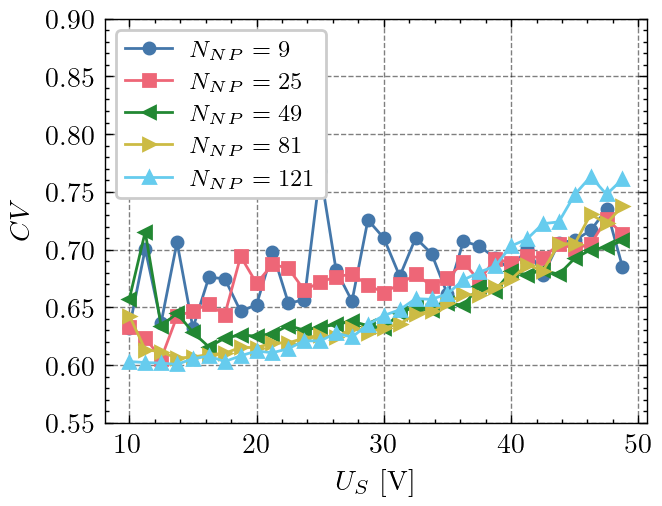

In [336]:
fig, ax = plt.subplots(dpi=200)
for i, N_NP in enumerate(N_PARTICLES):
    _ = ax.plot(np.array(U0_LIST[skip:])*1000, cvs_d[N_NP], marker=MARKERS[i], ls='-', ms=4, label='$N_{NP} = '+f'{N_NP**2}$')
_ = ax.set_xlabel("$U_S$ [V]")
_ = ax.set_ylabel("$CV$")
_ = ax.set_ylim(0.55,0.9)
_ = ax.legend(fontsize='small', loc='upper left')

fig.savefig(f"plots/png/relaxation/cv_vs_U.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/cv_vs_U.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/cv_vs_U.svg", transparent=True)

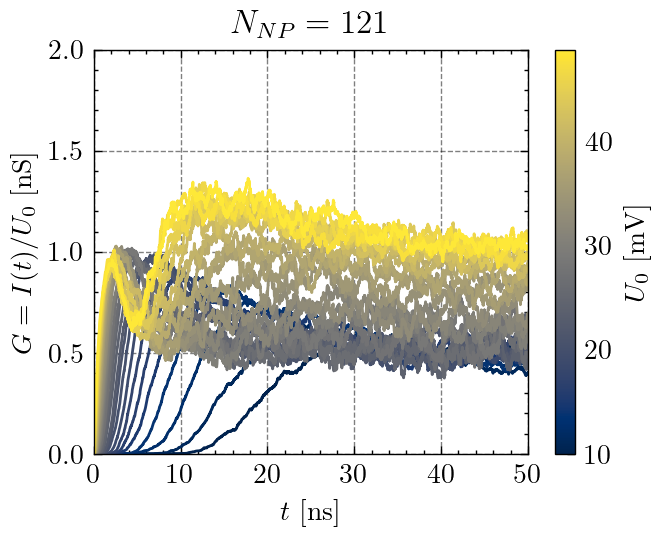

In [325]:
N_NP    = 11
fig, ax = plt.subplots(dpi=200)
for i, V in enumerate(U0_LIST):
    t_copy  = t.copy()*1e9
    y_copy  = (y_d[N_NP][:,i].copy()*1e-9)/V
    ye_copy = (ye_d[N_NP][:,i].copy()*1e-9)/V
    ax.plot(t_copy, y_copy, color=CMAP(PLOT_NORM(V*1000)))
    
_ = ax.set_xlabel("$t$ [ns]")
_ = ax.set_ylabel("$G = I(t)/U_0$ [nS]")
_ = ax.set_xlim(0, 5000*TIME_STEP*1e9)
_ = ax.set_ylim(0, 2.0)
_ = ax.set_title("$N_{NP}"+f" = {N_NP**2}$")
sm  = ScalarMappable(cmap=CMAP, norm=PLOT_NORM)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$U_0$ [mV]")

fig.savefig(f"plots/png/relaxation/N={N_NP}_N={N_NP}_G_vs_t.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/N={N_NP}_N={N_NP}_G_vs_t.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/N={N_NP}_N={N_NP}_G_vs_t.svg", transparent=True)

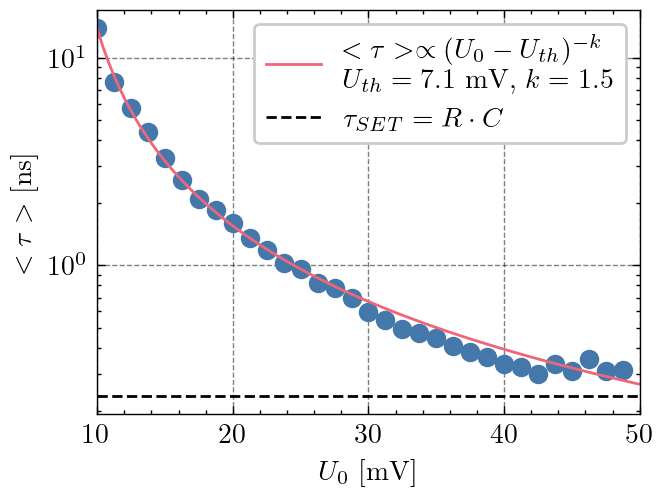

In [112]:
def power_law1(x, A, k, tau0):
    return tau0 + A*x**(-k)
def power_law2(x, A, k, V_th):
    return A*(x-V_th)**(-k)
def power_law3(x, A, k, tau0, V_th):
    return tau0 + A*(x-V_th)**(-k)

V_write     = np.array(U0_LIST[skip:])*1000
V_clean     = V_write[V_write < 40]
tau_clean   = np.array(taus)[V_write < 40]
p, cov      = curve_fit(power_law2, V_clean, tau_clean, bounds=[[0,0,0],[np.inf,np.inf,10]])
V_fit       = np.linspace(10, 50, 100)
tau_fit     = power_law2(V_fit, *p)

fig, ax = plt.subplots(dpi=200)
_ = ax.plot(np.array(U0_LIST[skip:])*1000, taus, 'o')#, label='$<\\tau> = \\frac{\\tau_K}{\\beta}\\Gamma(\\frac{1}{\\beta})$')
_ = ax.plot(V_fit, tau_fit, label='$<\\tau>\\propto (U_0 - U_{th})^{-k}$\n$U_{th} = '+f'{p[2].round(1)}$ mV, $k = {p[1].round(1)}$')
_ = ax.hlines(tau_t, 10, 50, colors='black', label='$\\tau_{SET} = R \cdot C$', ls='--')
_ = ax.legend()
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$<\\tau>$ [ns]")
_ = ax.set_xlim(10, 50)
_ = ax.set_yscale('log')

fig.savefig(f"plots/png/DC/N={N_PARTICLES}_N={N_PARTICLES}_tau_vs_U.png", transparent=False)
fig.savefig(f"plots/pdf/DC/N={N_PARTICLES}_N={N_PARTICLES}_tau_vs_U.pdf", transparent=False)
fig.savefig(f"plots/svg/DC/N={N_PARTICLES}_N={N_PARTICLES}_tau_vs_U.svg", transparent=True)